In [1]:
##The dataset is loaded to your GDrive so need to be mounted
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Satellite Project/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
saved_model_name = 'BasicUNet_diff.pt'
START_IDX = 0

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import jaccard_score

import random
import time
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob

from utils import *
from models.basic_unet import UNet
from datasets.diff_dataset import ChangeDetectionDiffDataset

## Read Data

In [4]:
training_path = './trainval/'

In [5]:
# after_images = read_data(training_path, 'after',START_IDX)
# before_images = read_data(training_path,'before',START_IDX)
# labels = read_data(training_path,'label',START_IDX)

# diff_images = preprocess(before_images, after_images, save_dir=training_path)

In [6]:
diff_images = read_data(training_path,'diff',START_IDX)
labels = read_data(training_path,'label',START_IDX)

Time taken to read  diff  images: 157.97 seconds
Time taken to read  label  images: 199.69 seconds


In [7]:
print(len(diff_images))
print(len(labels))

4868
4868


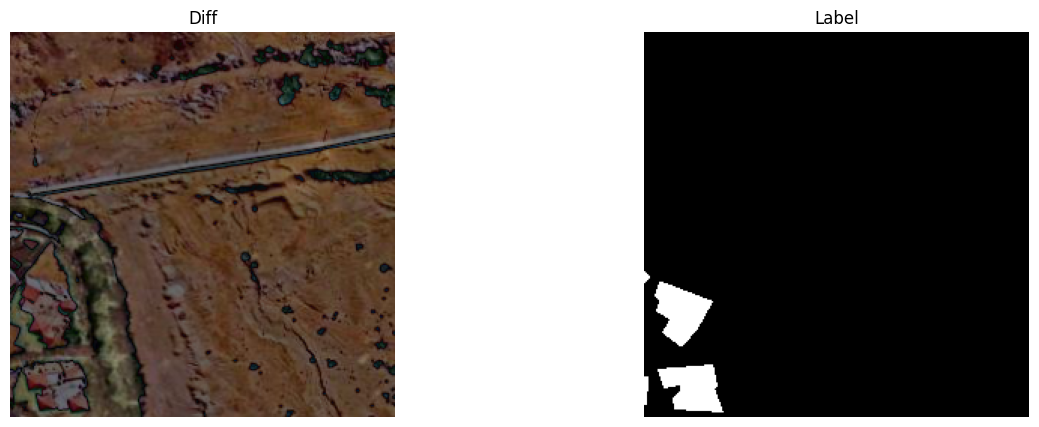

In [8]:
index = 3
display_images([diff_images[index]], labels[index])

## Create Datasets

In [9]:
batch_size = 32
train_val_ratio = 0.8

In [10]:
# Define transformations
transform_rgb = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_label = transforms.Compose([
    transforms.ToTensor(),
])

# Assuming you have instantiated your dataset like this
dataset = ChangeDetectionDiffDataset(diff_images, labels, transform_rgb, transform_label)

# Define the indices for train and validation sets
train_size = int(train_val_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders for train and validation sets
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle = True)

In [11]:
print("Percentage of pure black masks in training set:", count_pure_black_masks(train_loader))
print("Percentage of pure black masks in validation set:", count_pure_black_masks(val_loader))

Percentage of pure black masks in training set: 67.05187467899333
Percentage of pure black masks in validation set: 63.75770020533881


In [12]:
print("Train size:", len(train_loader) * batch_size)
print("Validation size:", len(val_loader) * batch_size)

Train size: 3900
Validation size: 990


In [13]:
diff_image, label = train_dataset[0]
print(diff_image.shape)
print(label.shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [14]:
# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels = 3, n_classes = 1).to(device)
criterion = nn.BCEWithLogitsLoss()
print(device)

cuda


In [15]:
learning_rate = 0.001
threshold = 0.3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)

In [16]:
# from torchsummary import summary
# summary(model,input_size=[(3,256,256),(3,256,256)])

## Train Model

In [17]:
def train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=50, save_dir="saved_models"):
    n_steps = len(train_loader)
    jaccard_loss = 0
    best_jaccard_score = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_iou = 0.0

        predicted_masks_list = []
        true_masks_list = []
        for data in tqdm(train_loader):
            diff_image, true_masks = data
            diff_image = diff_image.to(device)
            true_masks = true_masks.to(device)

            optimizer.zero_grad()
            masks_pred = model(diff_image)  # Pass both before and after images to the model
            loss = criterion(masks_pred, true_masks)
            loss += 0.2 * jaccard_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            pred_masks = (masks_pred > threshold).float()

            for i, pred_mask in enumerate(pred_masks):
                pred_mask = pred_mask.squeeze().cpu().numpy()
                predicted_masks_list.append(pred_mask)

                true_mask = true_masks[i].squeeze().cpu().numpy()
                true_masks_list.append(true_mask)

            # Clearing unnecessary variables from GPU memory
            del diff_image, true_masks, masks_pred, loss

        epoch_iou, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
        epoch_loss = running_loss / n_steps
        jaccard_loss = 1 - epoch_iou

        print(f'Epoch [{epoch + 1}/{num_epochs}] Finished, Loss: {epoch_loss:.5f}, Jaccard Index: {epoch_iou:.5f}, Accuracy: {overall_accuracy:.5f}, Learning Rate: {optimizer.param_groups[0]["lr"]}')
        # Step the scheduler based on the validation IoU
        scheduler.step()

        model_path = os.path.join(save_dir, saved_model_name)
        if epoch_iou > best_jaccard_score:
            best_jaccard_score = epoch_iou
            print(f'Best Jaccard Index: {best_jaccard_score:.5f}')
            torch.save(model.state_dict(), model_path)

        running_loss = 0.0

In [18]:
# Train the model
train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=40, save_dir= "saved_models")

100%|██████████| 130/130 [03:23<00:00,  1.57s/it]


Epoch [1/40] Finished, Loss: 0.34117, Jaccard Index: 0.61311, Accuracy: 0.92072, Learning Rate: 0.001
Best Jaccard Index: 0.61311


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [2/40] Finished, Loss: 0.24307, Jaccard Index: 0.67563, Accuracy: 0.93447, Learning Rate: 0.001
Best Jaccard Index: 0.67563


100%|██████████| 130/130 [03:27<00:00,  1.60s/it]


Epoch [3/40] Finished, Loss: 0.20983, Jaccard Index: 0.69099, Accuracy: 0.94049, Learning Rate: 0.001
Best Jaccard Index: 0.69099


100%|██████████| 130/130 [03:28<00:00,  1.61s/it]


Epoch [4/40] Finished, Loss: 0.19629, Jaccard Index: 0.69865, Accuracy: 0.94514, Learning Rate: 0.001
Best Jaccard Index: 0.69865


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [5/40] Finished, Loss: 0.18949, Jaccard Index: 0.71458, Accuracy: 0.94678, Learning Rate: 0.001
Best Jaccard Index: 0.71458


100%|██████████| 130/130 [03:27<00:00,  1.60s/it]


Epoch [6/40] Finished, Loss: 0.18422, Jaccard Index: 0.71139, Accuracy: 0.94798, Learning Rate: 0.001


100%|██████████| 130/130 [03:27<00:00,  1.60s/it]


Epoch [7/40] Finished, Loss: 0.17755, Jaccard Index: 0.72555, Accuracy: 0.95061, Learning Rate: 0.001
Best Jaccard Index: 0.72555


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [8/40] Finished, Loss: 0.16972, Jaccard Index: 0.73705, Accuracy: 0.95307, Learning Rate: 0.001
Best Jaccard Index: 0.73705


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [9/40] Finished, Loss: 0.16385, Jaccard Index: 0.73836, Accuracy: 0.95421, Learning Rate: 0.001
Best Jaccard Index: 0.73836


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [10/40] Finished, Loss: 0.15859, Jaccard Index: 0.74510, Accuracy: 0.95630, Learning Rate: 0.001
Best Jaccard Index: 0.74510


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [11/40] Finished, Loss: 0.14757, Jaccard Index: 0.76424, Accuracy: 0.95980, Learning Rate: 0.0002
Best Jaccard Index: 0.76424


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [12/40] Finished, Loss: 0.14017, Jaccard Index: 0.77088, Accuracy: 0.96124, Learning Rate: 0.0002
Best Jaccard Index: 0.77088


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [13/40] Finished, Loss: 0.13834, Jaccard Index: 0.77107, Accuracy: 0.96160, Learning Rate: 0.0002
Best Jaccard Index: 0.77107


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [14/40] Finished, Loss: 0.13541, Jaccard Index: 0.77951, Accuracy: 0.96230, Learning Rate: 0.0002
Best Jaccard Index: 0.77951


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [15/40] Finished, Loss: 0.13302, Jaccard Index: 0.77265, Accuracy: 0.96285, Learning Rate: 0.0002


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [16/40] Finished, Loss: 0.13360, Jaccard Index: 0.77862, Accuracy: 0.96306, Learning Rate: 0.0002


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [17/40] Finished, Loss: 0.13193, Jaccard Index: 0.78138, Accuracy: 0.96323, Learning Rate: 0.0002
Best Jaccard Index: 0.78138


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [18/40] Finished, Loss: 0.12893, Jaccard Index: 0.78314, Accuracy: 0.96396, Learning Rate: 0.0002
Best Jaccard Index: 0.78314


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [19/40] Finished, Loss: 0.12679, Jaccard Index: 0.78305, Accuracy: 0.96472, Learning Rate: 0.0002


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [20/40] Finished, Loss: 0.12426, Jaccard Index: 0.79112, Accuracy: 0.96578, Learning Rate: 0.0002
Best Jaccard Index: 0.79112


100%|██████████| 130/130 [03:28<00:00,  1.61s/it]


Epoch [21/40] Finished, Loss: 0.11761, Jaccard Index: 0.79820, Accuracy: 0.96790, Learning Rate: 4e-05
Best Jaccard Index: 0.79820


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [22/40] Finished, Loss: 0.11471, Jaccard Index: 0.79554, Accuracy: 0.96823, Learning Rate: 4e-05


100%|██████████| 130/130 [03:28<00:00,  1.61s/it]


Epoch [23/40] Finished, Loss: 0.11440, Jaccard Index: 0.80221, Accuracy: 0.96870, Learning Rate: 4e-05
Best Jaccard Index: 0.80221


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [24/40] Finished, Loss: 0.11283, Jaccard Index: 0.80263, Accuracy: 0.96873, Learning Rate: 4e-05
Best Jaccard Index: 0.80263


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [25/40] Finished, Loss: 0.11145, Jaccard Index: 0.80065, Accuracy: 0.96929, Learning Rate: 4e-05


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [26/40] Finished, Loss: 0.11129, Jaccard Index: 0.80400, Accuracy: 0.96956, Learning Rate: 4e-05
Best Jaccard Index: 0.80400


100%|██████████| 130/130 [03:28<00:00,  1.61s/it]


Epoch [27/40] Finished, Loss: 0.11103, Jaccard Index: 0.80175, Accuracy: 0.96944, Learning Rate: 4e-05


100%|██████████| 130/130 [03:28<00:00,  1.61s/it]


Epoch [28/40] Finished, Loss: 0.10983, Jaccard Index: 0.80660, Accuracy: 0.97001, Learning Rate: 4e-05
Best Jaccard Index: 0.80660


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [29/40] Finished, Loss: 0.10956, Jaccard Index: 0.79852, Accuracy: 0.97005, Learning Rate: 4e-05


100%|██████████| 130/130 [03:28<00:00,  1.61s/it]


Epoch [30/40] Finished, Loss: 0.11002, Jaccard Index: 0.80917, Accuracy: 0.97023, Learning Rate: 4e-05
Best Jaccard Index: 0.80917


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [31/40] Finished, Loss: 0.10636, Jaccard Index: 0.80697, Accuracy: 0.97139, Learning Rate: 8.000000000000001e-06


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [32/40] Finished, Loss: 0.10573, Jaccard Index: 0.80711, Accuracy: 0.97165, Learning Rate: 8.000000000000001e-06


100%|██████████| 130/130 [03:28<00:00,  1.60s/it]


Epoch [33/40] Finished, Loss: 0.10596, Jaccard Index: 0.80920, Accuracy: 0.97138, Learning Rate: 8.000000000000001e-06
Best Jaccard Index: 0.80920


100%|██████████| 130/130 [03:28<00:00,  1.61s/it]


Epoch [34/40] Finished, Loss: 0.10488, Jaccard Index: 0.81093, Accuracy: 0.97184, Learning Rate: 8.000000000000001e-06
Best Jaccard Index: 0.81093


100%|██████████| 130/130 [03:29<00:00,  1.61s/it]


Epoch [35/40] Finished, Loss: 0.10459, Jaccard Index: 0.81087, Accuracy: 0.97171, Learning Rate: 8.000000000000001e-06


100%|██████████| 130/130 [03:29<00:00,  1.61s/it]


Epoch [36/40] Finished, Loss: 0.10479, Jaccard Index: 0.80727, Accuracy: 0.97163, Learning Rate: 8.000000000000001e-06


100%|██████████| 130/130 [03:29<00:00,  1.61s/it]


Epoch [37/40] Finished, Loss: 0.10447, Jaccard Index: 0.81201, Accuracy: 0.97211, Learning Rate: 8.000000000000001e-06
Best Jaccard Index: 0.81201


100%|██████████| 130/130 [03:29<00:00,  1.61s/it]


Epoch [38/40] Finished, Loss: 0.10459, Jaccard Index: 0.80814, Accuracy: 0.97165, Learning Rate: 8.000000000000001e-06


100%|██████████| 130/130 [03:29<00:00,  1.61s/it]


Epoch [39/40] Finished, Loss: 0.10480, Jaccard Index: 0.81228, Accuracy: 0.97197, Learning Rate: 8.000000000000001e-06
Best Jaccard Index: 0.81228


100%|██████████| 130/130 [03:29<00:00,  1.61s/it]


Epoch [40/40] Finished, Loss: 0.10362, Jaccard Index: 0.81065, Accuracy: 0.97202, Learning Rate: 8.000000000000001e-06


In [19]:
torch.cuda.empty_cache()

In [20]:
# # Load the latest saved model
# model = load_model(model, save_dir="saved_models", model_name=saved_model_name)

## Validate Model

In [28]:
diff_images_list, predicted_masks_list, true_masks_list = validate_diff(model, val_loader, device, threshold)

In [29]:
jaccard, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
print("Mean Jaccard Index :", jaccard)
print("Overall Accuracy :", overall_accuracy)

Mean Jaccard Index : 0.7733283524289287
Overall Accuracy : 0.9639484162692906


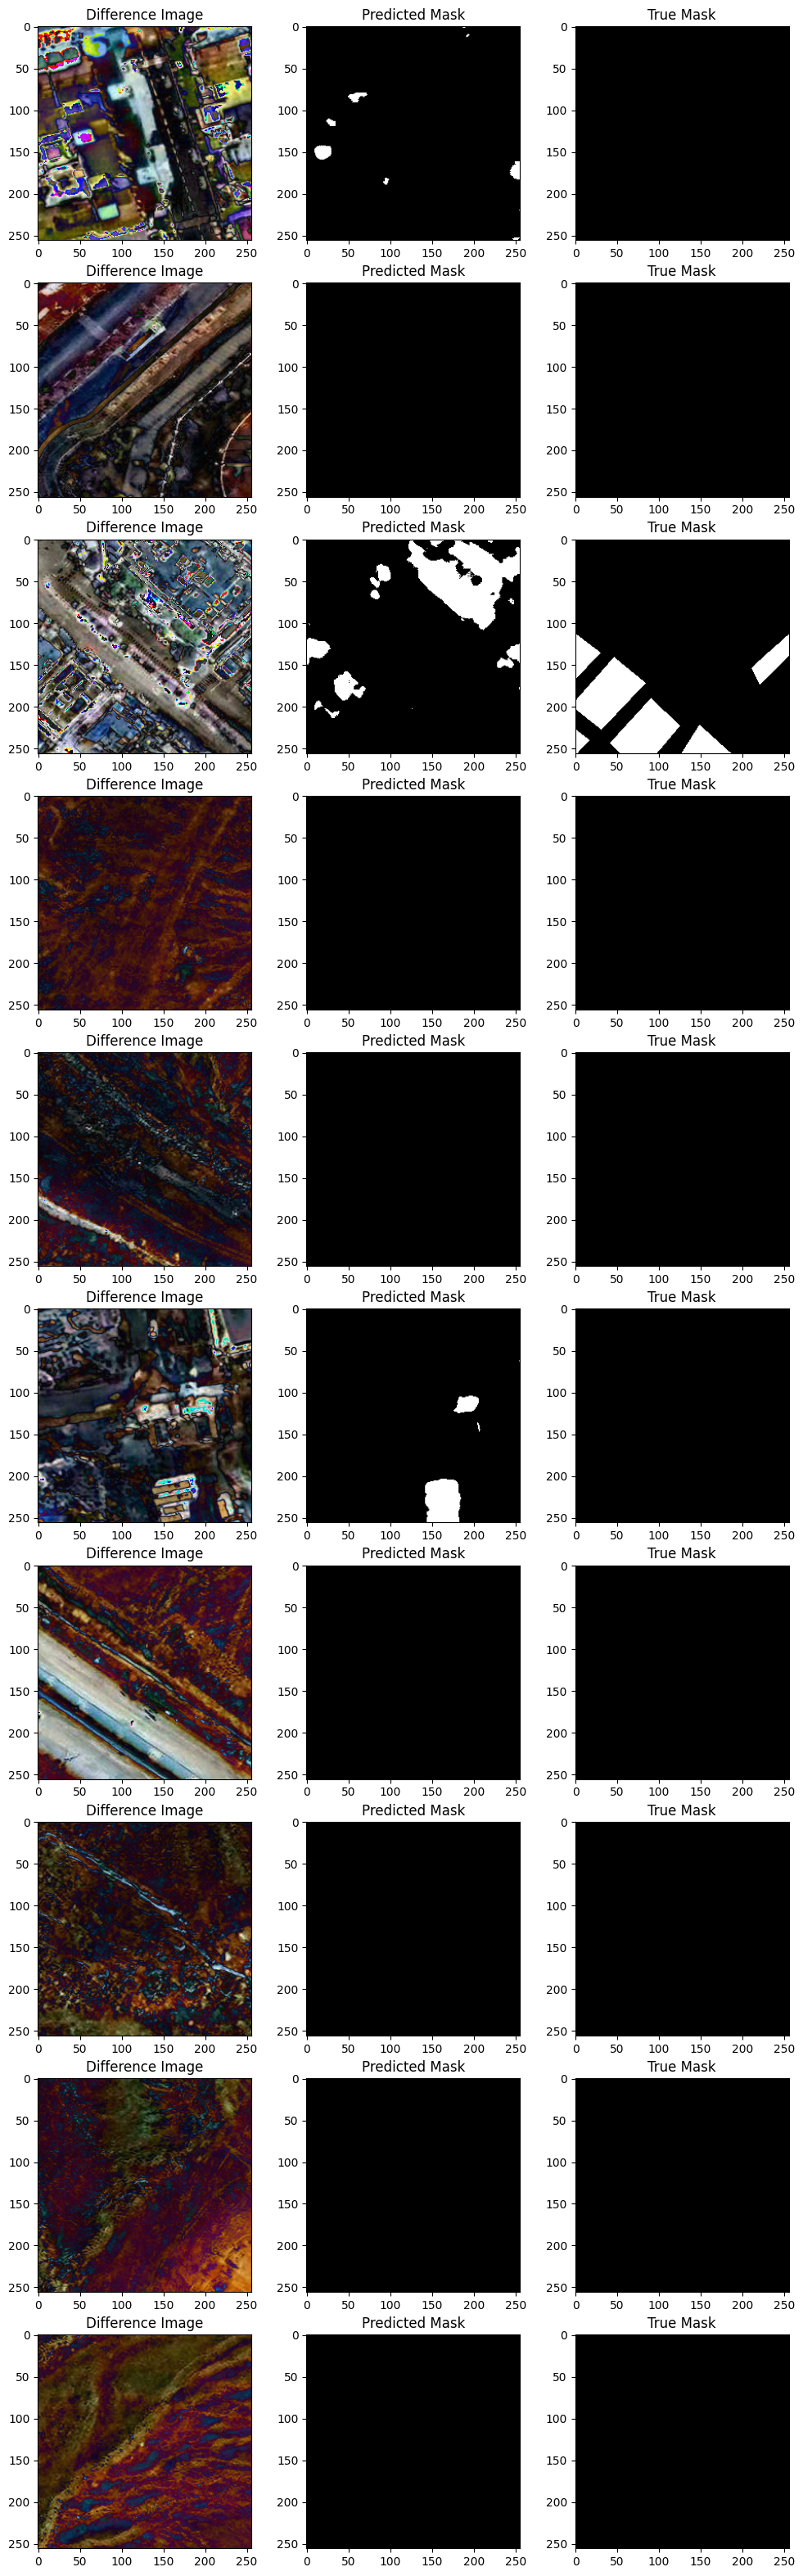

In [31]:
display_predicted_images_diff(diff_images_list, predicted_masks_list, true_masks_list)

In [24]:
# save_predictions(predicted_masks_list, predicted_images_dir)